# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [3]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [4]:
df_grid = gen_tp_data(n=5000, grid=True)

In [5]:
df_grid

,x,y,eta,z
0,0.000000,0.0,1.162528e-19,0.103675
1,0.014286,0.0,1.344590e-01,0.380944
2,0.028571,0.0,2.678353e-01,0.366966
3,0.042857,0.0,3.990553e-01,0.008108
4,0.057143,0.0,5.270622e-01,0.798669
...,...,...,...,...
5036,0.942857,1.0,1.281348e+00,1.076909
5037,0.957143,1.0,1.164770e+00,1.171729
5038,0.971429,1.0,1.044978e+00,1.027468
5039,0.985714,1.0,9.230304e-01,0.818835


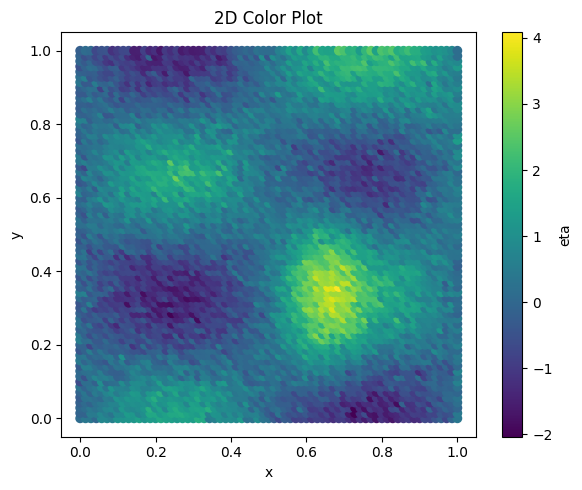

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [7]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [8]:
tb = gam.TermBuilder.from_df(df)

In [9]:
loc += tb.te("x", "y", bs=("ts", "cp"))

Warning message:
In smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots) :
  reparameterization unstable for margin: not done
Warning message:
In smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots) :
  reparameterization unstable for margin: not done


### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


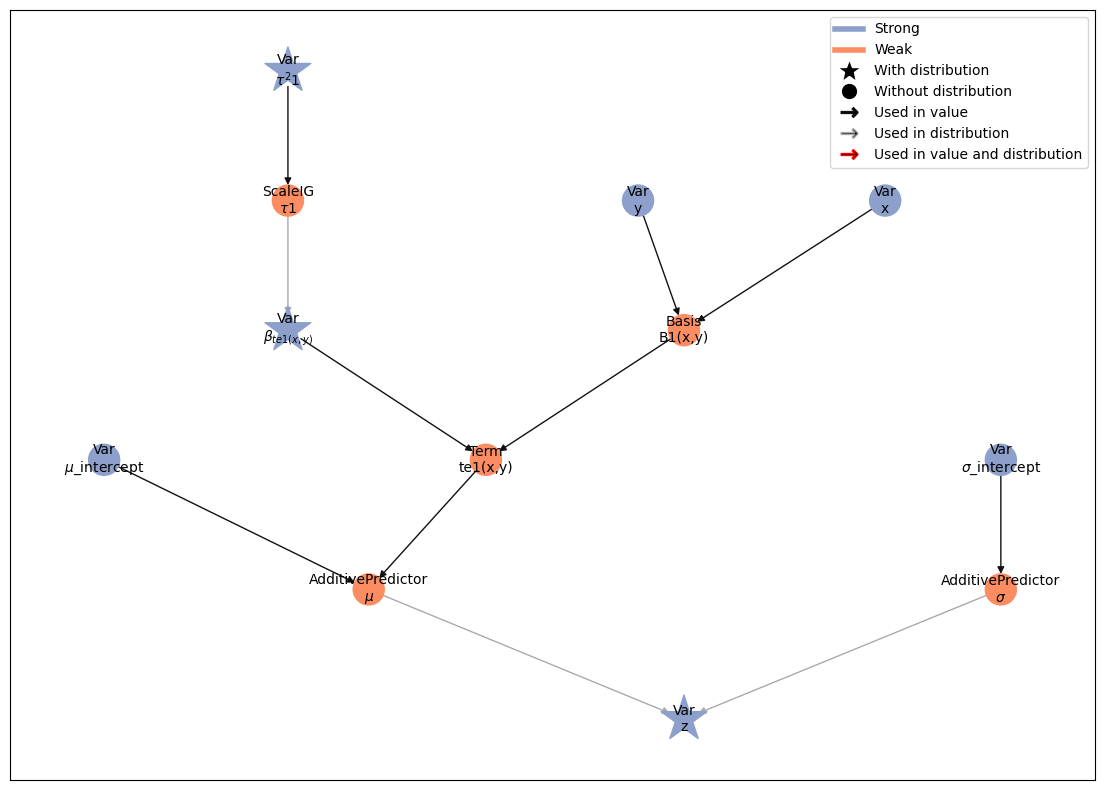

In [10]:
model = lsl.Model([z])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [11]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{te1(x,y)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:02<00:00,  3.20chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 985.04chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1589.65chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Start

### MCMC summary

In [12]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{te1(x,y)}$ (0,)   kernel_02 -0.347957  0.464650 -1.109962 -0.342575   
                   (1,)   kernel_02  0.035715  0.435870 -0.701389  0.030936   
                   (2,)   kernel_02 -0.321384  0.396022 -0.938165 -0.314915   
                   (3,)   kernel_02  0.121526  0.418557 -0.581825  0.106517   
                   (4,)   kernel_02 -0.838262  0.281917 -1.282560 -0.836497   
                   (5,)   kernel_02  0.274726  0.229167 -0.124090  0.277943   
                   (6,)   kernel_02  0.209059  0.297467 -0.271451  0.214677   
                   (7,)   kernel_02 -3.791652  0.274536 -4.242257 -3.786641   
                   (8,)   kernel_02  3.277575  0.261197  2.852783  3.274459   
                   (9,)   kernel_02  0.507204  0.223511  0.143901  0.500290   
                   (10,)  kernel_02 -0.501769  0.246277 -0.891216 -0.510315   
                   (11,)  kernel_02  0.498043  0.233107  0.112768  0.495544   
                   (12,)  kernel_02  0.764588  0.240475  0.373249  0.764235   
                   (13,)  kernel_02 -0.193277  0.262312 -0.659017 -0.180958   
                   (14,)  kernel_02  0.918386  0.253292  0.500669  0.921252   
                   (15,)  kernel_02  0.435973  0.252863  0.001178  0.435934   
                   (16,)  kernel_02 -0.215066  0.261590 -0.650146 -0.217645   
                   (17,)  kernel_02  4.672657  0.250079  4.263008  4.659555   
                   (18,)  kernel_02 -3.138406  0.267513 -3.545020 -3.148455   
                   (19,)  kernel_02  0.992667  0.417353  0.327918  1.007021   
                   (20,)  kernel_02 -0.260141  0.525712 -1.171420 -0.254200   
                   (21,)  kernel_02 -0.837268  0.415921 -1.535462 -0.851312   
                   (22,)  kernel_02 -0.259941  0.456588 -1.011718 -0.282963   
                   (23,)  kernel_02 -0.771869  0.454235 -1.537983 -0.763519   
$\mu$_intercept    ()     kernel_01  0.362054  0.024031  0.322192  0.361399   
$\sigma$_intercept ()     kernel_00 -0.539109  0.029537 -0.586012 -0.540281   
$\tau^2$1          ()     kernel_03  5.180987  1.544524  3.151127  4.934046   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{te1(x,y)}$ (0,)   0.370611          800  336.744407  680.930042   
                   (1,)   0.732164          800  258.253547  608.342461   
                   (2,)   0.329652          800  195.995088  633.446139   
                   (3,)   0.776440          800  434.036028  718.587335   
                   (4,)  -0.385977          800  438.188033  614.467712   
                   (5,)   0.634573          800  387.430284  592.474074   
                   (6,)   0.699962          800  439.026475  643.077820   
                   (7,)  -3.337823          800  380.831868  623.146095   
                   (8,)   3.704203          800  375.632401  570.651733   
                   (9,)   0.851861          800  362.659738  637.770037   
                   (10,) -0.096936          800  449.111513  550.143630   
                   (11,)  0.908301          800  488.185819  737.022136   
                   (12,)  1.173429          800  370.220841  544.005770   
                   (13,)  0.225023          800  488.301271  614.761865   
                   (14,)  1.338557          800  433.357640  632.543470   
                   (15,)  0.841666          800  423.988682  634.577724   
                   (16,)  0.244622          800  359.684348  554.029748   
                   (17,)  5.085597          800  441.646595  637.193407   
                   (18,) -2.664692          800  383.352770  543.874442   
                   (19,)  1.634942          800  475.571447  628.192137   
                   (20,)  0.621018    

### MCMC trace plots

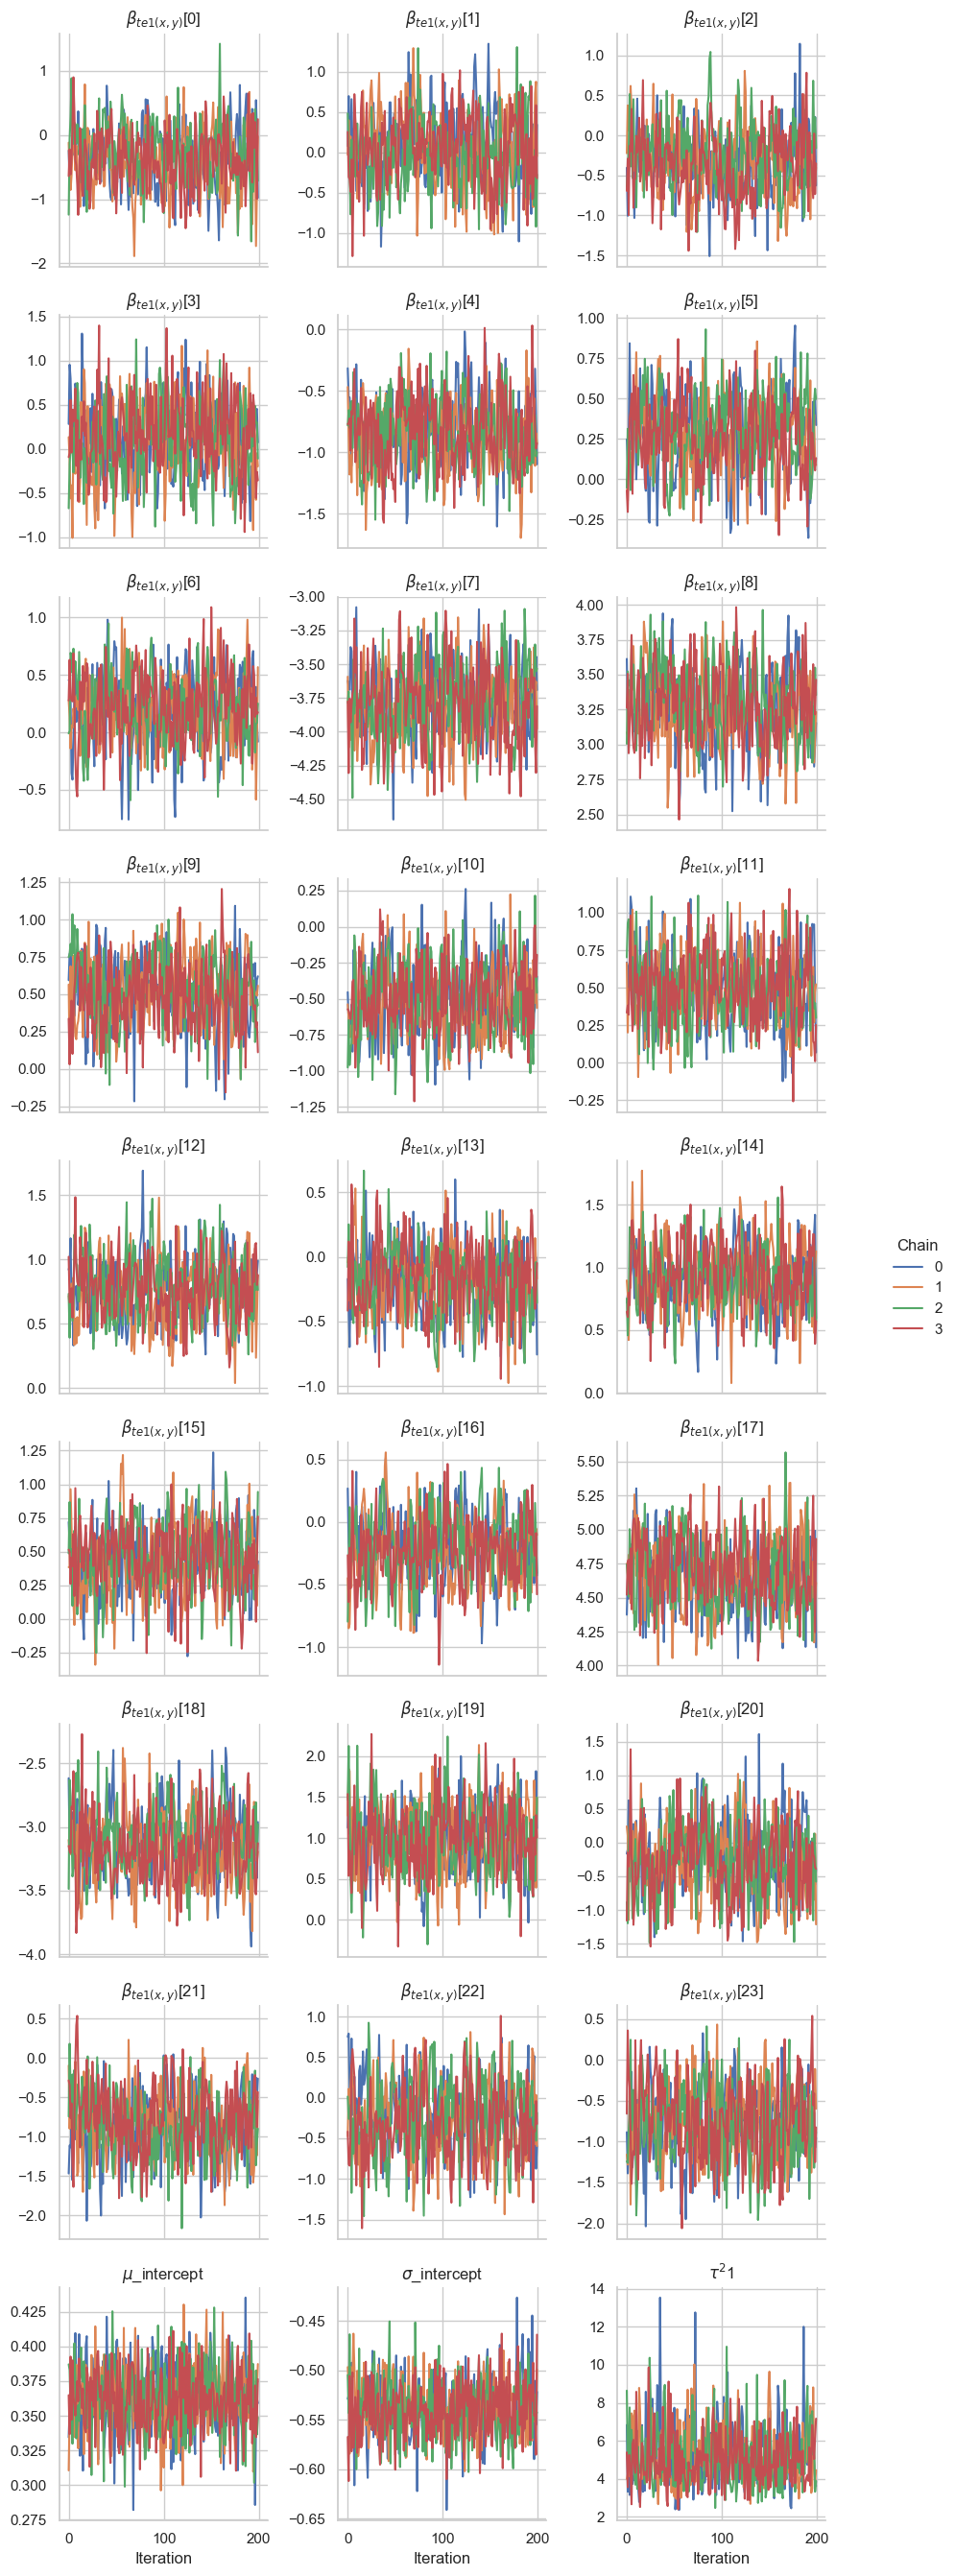

In [13]:
gs.plot_trace(results)

## Predictions

In [14]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [15]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["te1(x,y)", "$\\mu$"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0

In [16]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [17]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x,y
0,$\mu$,$\mu$[0],"(0,)",800,-0.024813,0.054222,0.232855,1.012101,385.299254,699.643235,0.011869,0.005957,-0.407070,-0.026585,0.353783,-0.386419,0.372019,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",800,0.008806,0.045320,0.212884,1.012370,386.692796,641.182939,0.010842,0.005481,-0.349735,0.007261,0.354283,-0.359365,0.330905,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",800,0.042364,0.037503,0.193657,1.012644,386.509155,615.049691,0.009851,0.005027,-0.275659,0.039159,0.359308,-0.283770,0.346488,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",800,0.075659,0.030784,0.175454,1.012668,387.596339,614.989249,0.008923,0.004600,-0.206829,0.076629,0.356162,-0.208020,0.352786,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",800,0.108359,0.025166,0.158638,1.013004,387.778597,567.595641,0.008067,0.004204,-0.146497,0.110639,0.364718,-0.149678,0.358891,0.057143,0.0


### Plot fitted functions

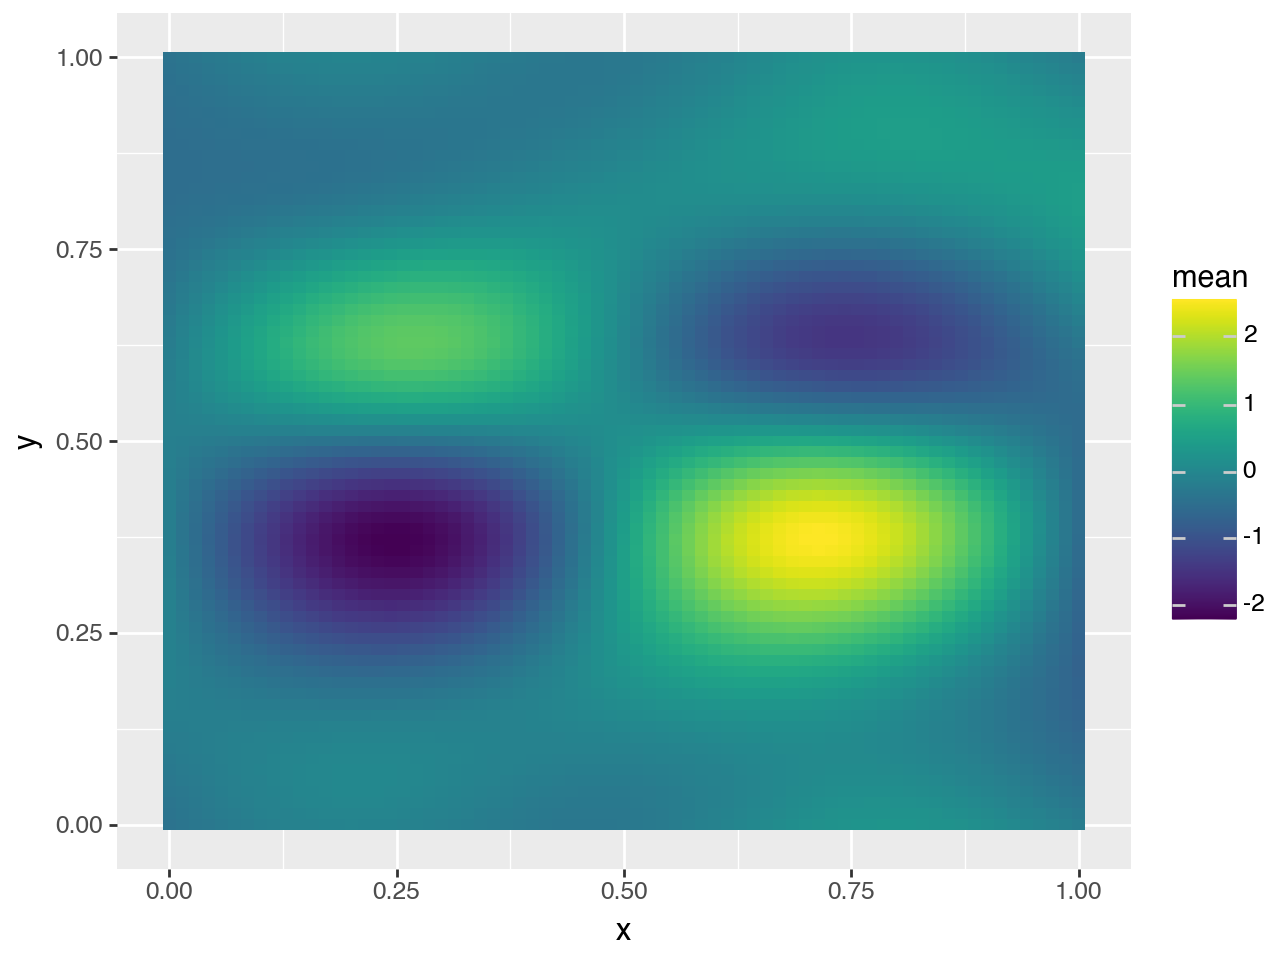

In [18]:
select = predictions_summary["variable"].isin(["te1(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

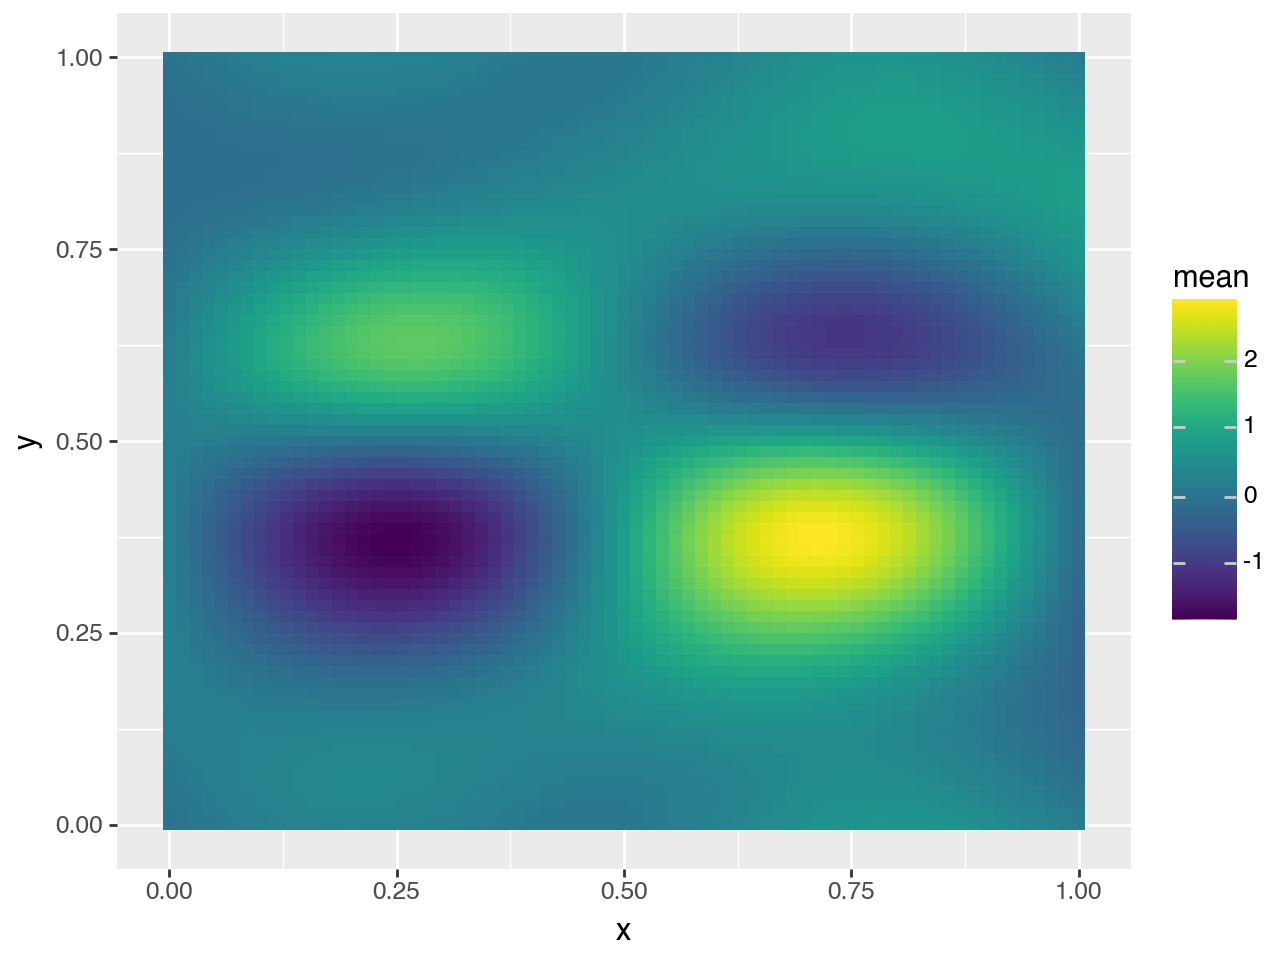

In [19]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

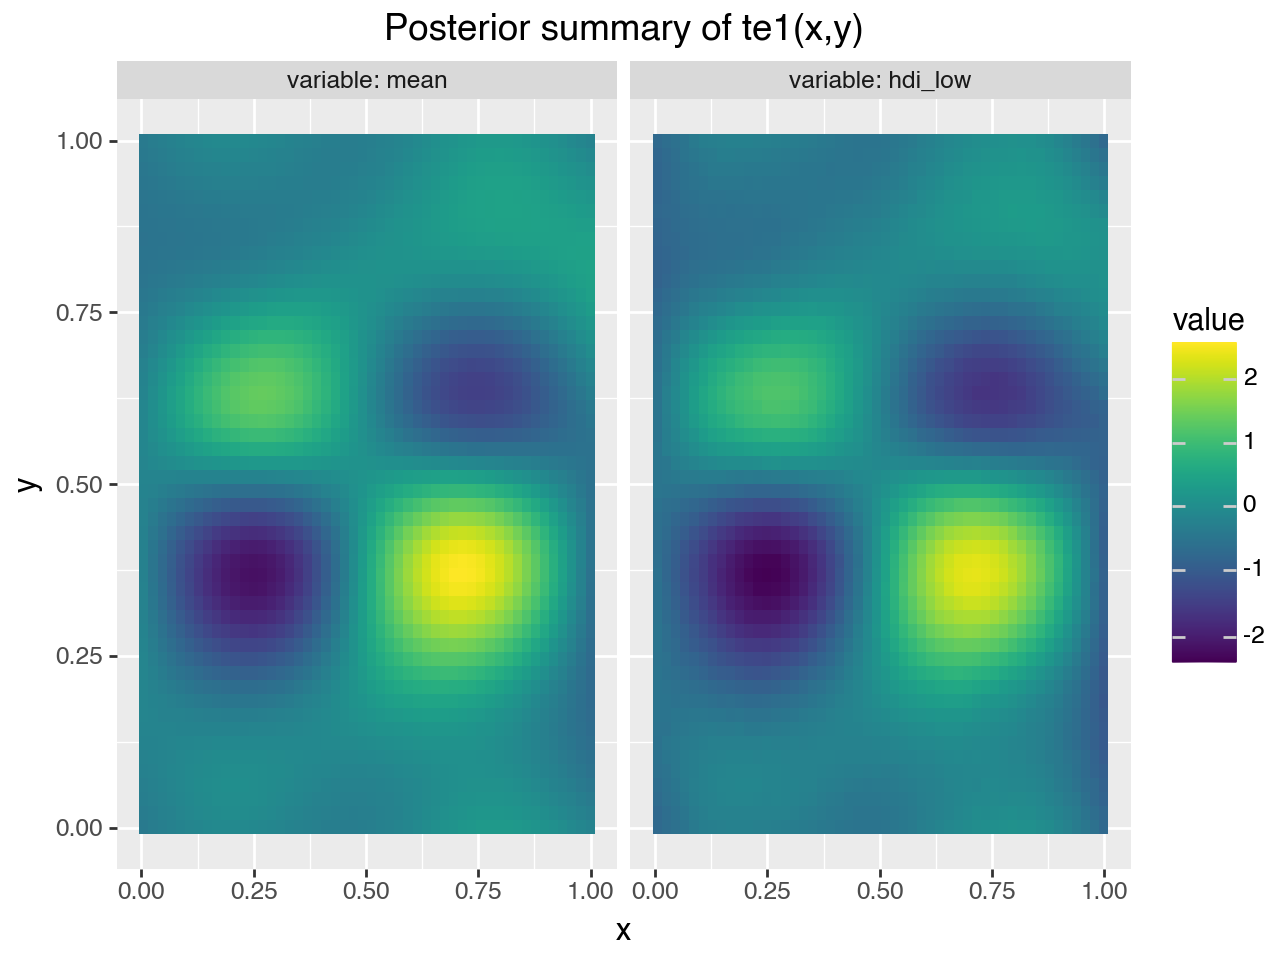

In [20]:
from liesel_gam.plots import plot_2d_smooth

plot_2d_smooth(
    loc.terms["te1(x,y)"], samples=samples, ngrid=50, plot_vars=["mean", "hdi_low"]
)